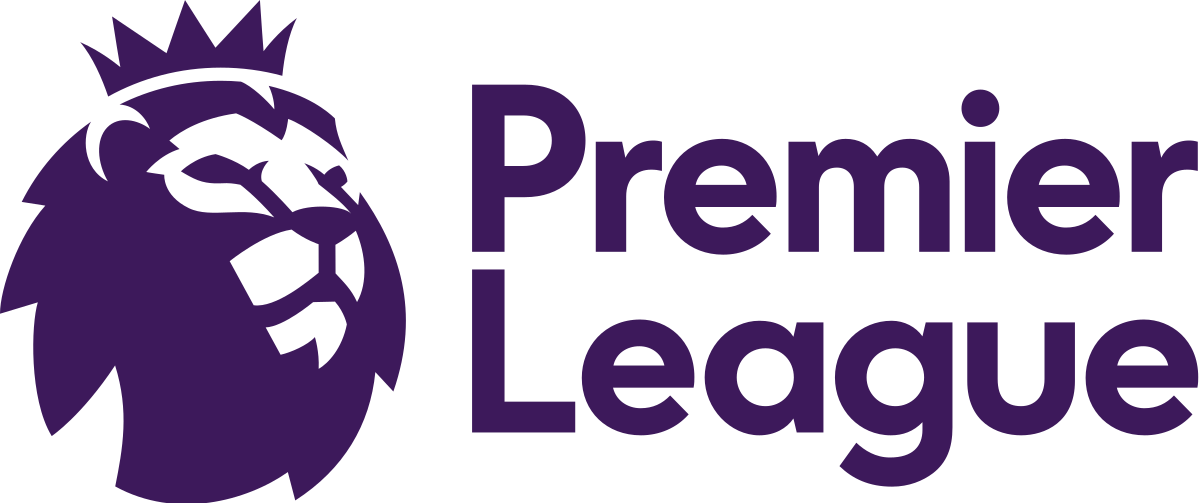

# In this notebook, We will build model for predictions of PL matches

##### Importing libraries that is needed for this project

In [1]:
import os 
import pandas as pd
pd.options.mode.chained_assignment = None
from IPython.display import display
import numpy as np
import unidecode
import copy
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from mplsoccer import Pitch, FontManager, add_image
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

C:\Users\othma\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Import Clean Scraped Data

In [2]:
seasons=["2021-2022","2020-2021","2019-2020"]
PL={}

for season in range(len(seasons)):
    
    #Import players each season
    PL["s"+seasons[season][:4]+"_players"]=pd.read_csv("PL_clean"+"/"+seasons[season][:4]+"/players.csv")
    
    #Import matches for every team in each season
    PL["s"+seasons[season][:4]+"_matches"]=pd.read_csv("PL_clean"+"/"+seasons[season][:4]+"/matches.csv")
    
    #Import goalkeepers in each season
    PL["s"+seasons[season][:4]+"_gk"]=pd.read_csv("PL_clean"+"/"+seasons[season][:4]+"/gk.csv")

## Exploring Data

### Display head of DataFrames

In [3]:
for season in range(len(seasons)):
    print("Matches for "+seasons[season])
    display(PL["s"+seasons[season][:4]+"_matches"].head())

Matches for 2021-2022


,Unnamed: 0,Date,Time,Round,Day,Team,Venue,Result,GF,GA,...,Performance | Int,Performance | TklW,Performance | PKwon,Performance | PKcon,Performance | OG,Performance | Recov,Aerial Duels | Won,Aerial Duels | Lost,Aerial Duels | Won%,Poss
0,0,2021-08-15,16:30:00,1,Sun,Manchester City,Away,L,0,1,...,3,11,0,0,0,53,19,14,57.6,65
1,1,2021-08-21,15:00:00,2,Sat,Manchester City,Home,W,5,0,...,6,8,0,0,0,38,9,3,75.0,67
2,2,2021-08-28,12:30:00,3,Sat,Manchester City,Home,W,5,0,...,4,10,0,0,0,45,13,9,59.1,80
3,3,2021-09-11,15:00:00,4,Sat,Manchester City,Away,W,1,0,...,5,7,0,0,0,53,8,12,40.0,61
4,4,2021-09-18,15:00:00,5,Sat,Manchester City,Home,D,0,0,...,8,10,0,0,0,51,22,15,59.5,64


Matches for 2020-2021


,Unnamed: 0,Date,Time,Round,Day,Team,Venue,Result,GF,GA,...,Performance | Int,Performance | TklW,Performance | PKwon,Performance | PKcon,Performance | OG,Performance | Recov,Aerial Duels | Won,Aerial Duels | Lost,Aerial Duels | Won%,Poss
0,0,2020-09-21,20:15:00,2,Mon,Manchester City,Away,W,3,1,...,4,9,1,0,0,57,13,11,54.2,65
1,1,2020-09-27,16:30:00,3,Sun,Manchester City,Home,L,2,5,...,8,7,0,3,0,44,10,15,40.0,72
2,2,2020-10-03,17:30:00,4,Sat,Manchester City,Away,D,1,1,...,6,5,0,0,0,51,13,5,72.2,49
3,3,2020-10-17,17:30:00,5,Sat,Manchester City,Home,W,1,0,...,8,5,0,0,0,47,15,12,55.6,58
4,4,2020-10-24,12:30:00,6,Sat,Manchester City,Away,D,1,1,...,9,5,0,0,0,55,13,15,46.4,69


Matches for 2019-2020


,Unnamed: 0,Date,Time,Round,Day,Team,Venue,Result,GF,GA,...,Performance | Int,Performance | TklW,Performance | PKwon,Performance | PKcon,Performance | OG,Performance | Recov,Aerial Duels | Won,Aerial Duels | Lost,Aerial Duels | Won%,Poss
0,0,2019-08-09,20:00:00,1,Fri,Liverpool,Home,W,4,1,...,14,13,0,0,0,54,15,7,68.2,57
1,1,2019-08-17,15:00:00,2,Sat,Liverpool,Away,W,2,1,...,10,2,0,0,0,52,19,15,55.9,63
2,2,2019-08-24,17:30:00,3,Sat,Liverpool,Home,W,3,1,...,9,17,1,0,0,54,7,11,38.9,52
3,3,2019-08-31,17:30:00,4,Sat,Liverpool,Away,W,3,0,...,9,6,0,0,0,61,23,21,52.3,63
4,4,2019-09-14,12:30:00,5,Sat,Liverpool,Home,W,3,1,...,8,11,0,0,0,65,25,13,65.8,74


### Columns of DataFrames

In [4]:
for season in range(len(seasons)):
    print("Matches for "+seasons[season])
    display(PL["s"+seasons[season][:4]+"_matches"].info(verbose=True))

Matches for 2021-2022
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760 entries, 0 to 759
Data columns (total 156 columns):
 #    Column                 Dtype  
---   ------                 -----  
 0    Unnamed: 0             int64  
 1    Date                   object 
 2    Time                   object 
 3    Round                  int64  
 4    Day                    object 
 5    Team                   object 
 6    Venue                  object 
 7    Result                 object 
 8    GF                     int64  
 9    GA                     int64  
 10   Opponent               object 
 11   xG                     float64
 12   xGA                    float64
 13   Attendance             int64  
 14   Captain                object 
 15   Formation              object 
 16   Referee                object 
 17   Standard | Gls         int64  
 18   Standard | Sh          int64  
 19   Standard | SoT         int64  
 20   Standard | SoT%        float64
 21   Standard | G/Sh

None

Matches for 2020-2021
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760 entries, 0 to 759
Data columns (total 156 columns):
 #    Column                 Dtype  
---   ------                 -----  
 0    Unnamed: 0             int64  
 1    Date                   object 
 2    Time                   object 
 3    Round                  int64  
 4    Day                    object 
 5    Team                   object 
 6    Venue                  object 
 7    Result                 object 
 8    GF                     int64  
 9    GA                     int64  
 10   Opponent               object 
 11   xG                     float64
 12   xGA                    float64
 13   Attendance             float64
 14   Captain                object 
 15   Formation              object 
 16   Referee                object 
 17   Standard | Gls         int64  
 18   Standard | Sh          int64  
 19   Standard | SoT         int64  
 20   Standard | SoT%        float64
 21   Standard | G/Sh

None

Matches for 2019-2020
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760 entries, 0 to 759
Data columns (total 156 columns):
 #    Column                 Dtype  
---   ------                 -----  
 0    Unnamed: 0             int64  
 1    Date                   object 
 2    Time                   object 
 3    Round                  int64  
 4    Day                    object 
 5    Team                   object 
 6    Venue                  object 
 7    Result                 object 
 8    GF                     int64  
 9    GA                     int64  
 10   Opponent               object 
 11   xG                     float64
 12   xGA                    float64
 13   Attendance             float64
 14   Captain                object 
 15   Formation              object 
 16   Referee                object 
 17   Standard | Gls         int64  
 18   Standard | Sh          int64  
 19   Standard | SoT         int64  
 20   Standard | SoT%        float64
 21   Standard | G/Sh

None

## Drop First Column

In [5]:
for season in range(len(seasons)):
    #Drop First Column in every DataFrame for every season
    PL["s"+seasons[season][:4]+"_matches"]=PL["s"+seasons[season][:4]+"_matches"].drop(columns=["Unnamed: 0"])
    PL["s"+seasons[season][:4]+"_players"]=PL["s"+seasons[season][:4]+"_players"].drop(columns=["Unnamed: 0"])
    PL["s"+seasons[season][:4]+"_gk"]=PL["s"+seasons[season][:4]+"_gk"].drop(columns=["Unnamed: 0"])

### Display head of DataFrames

In [6]:
for season in range(len(seasons)):
    print("Matches for "+seasons[season])
    display(PL["s"+seasons[season][:4]+"_matches"].head())

Matches for 2021-2022


,Date,Time,Round,Day,Team,Venue,Result,GF,GA,Opponent,...,Performance | Int,Performance | TklW,Performance | PKwon,Performance | PKcon,Performance | OG,Performance | Recov,Aerial Duels | Won,Aerial Duels | Lost,Aerial Duels | Won%,Poss
0,2021-08-15,16:30:00,1,Sun,Manchester City,Away,L,0,1,Tottenham,...,3,11,0,0,0,53,19,14,57.6,65
1,2021-08-21,15:00:00,2,Sat,Manchester City,Home,W,5,0,Norwich City,...,6,8,0,0,0,38,9,3,75.0,67
2,2021-08-28,12:30:00,3,Sat,Manchester City,Home,W,5,0,Arsenal,...,4,10,0,0,0,45,13,9,59.1,80
3,2021-09-11,15:00:00,4,Sat,Manchester City,Away,W,1,0,Leicester City,...,5,7,0,0,0,53,8,12,40.0,61
4,2021-09-18,15:00:00,5,Sat,Manchester City,Home,D,0,0,Southampton,...,8,10,0,0,0,51,22,15,59.5,64


Matches for 2020-2021


,Date,Time,Round,Day,Team,Venue,Result,GF,GA,Opponent,...,Performance | Int,Performance | TklW,Performance | PKwon,Performance | PKcon,Performance | OG,Performance | Recov,Aerial Duels | Won,Aerial Duels | Lost,Aerial Duels | Won%,Poss
0,2020-09-21,20:15:00,2,Mon,Manchester City,Away,W,3,1,Wolves,...,4,9,1,0,0,57,13,11,54.2,65
1,2020-09-27,16:30:00,3,Sun,Manchester City,Home,L,2,5,Leicester City,...,8,7,0,3,0,44,10,15,40.0,72
2,2020-10-03,17:30:00,4,Sat,Manchester City,Away,D,1,1,Leeds United,...,6,5,0,0,0,51,13,5,72.2,49
3,2020-10-17,17:30:00,5,Sat,Manchester City,Home,W,1,0,Arsenal,...,8,5,0,0,0,47,15,12,55.6,58
4,2020-10-24,12:30:00,6,Sat,Manchester City,Away,D,1,1,West Ham,...,9,5,0,0,0,55,13,15,46.4,69


Matches for 2019-2020


,Date,Time,Round,Day,Team,Venue,Result,GF,GA,Opponent,...,Performance | Int,Performance | TklW,Performance | PKwon,Performance | PKcon,Performance | OG,Performance | Recov,Aerial Duels | Won,Aerial Duels | Lost,Aerial Duels | Won%,Poss
0,2019-08-09,20:00:00,1,Fri,Liverpool,Home,W,4,1,Norwich City,...,14,13,0,0,0,54,15,7,68.2,57
1,2019-08-17,15:00:00,2,Sat,Liverpool,Away,W,2,1,Southampton,...,10,2,0,0,0,52,19,15,55.9,63
2,2019-08-24,17:30:00,3,Sat,Liverpool,Home,W,3,1,Arsenal,...,9,17,1,0,0,54,7,11,38.9,52
3,2019-08-31,17:30:00,4,Sat,Liverpool,Away,W,3,0,Burnley,...,9,6,0,0,0,61,23,21,52.3,63
4,2019-09-14,12:30:00,5,Sat,Liverpool,Home,W,3,1,Newcastle Utd,...,8,11,0,0,0,65,25,13,65.8,74


## Clean Formation Column

In [7]:
PL["s2019_matches"]["Formation"].unique()

array(['4-3-3', '4-2-3-1', '3-4-3', '3-4-1-2', '4-1-2-1-2◆', '4-1-4-1',
       '4-4-1-1', '3-1-4-2', '3-5-2', '4-4-2', '4-3-1-2', '4-2-2-2',
       '5-4-1', '4-3-2-1', '5-3-2', '4-5-1', '3-5-1-1'], dtype=object)

In [8]:
PL["s2020_matches"]["Formation"].unique()

array(['4-2-3-1', '4-3-3', '3-1-4-2', '3-4-3◆', '3-4-3', '4-4-1-1',
       '4-1-2-1-2◆', '4-3-1-2', '4-4-2', '4-2-2-2', '3-4-1-2', '3-5-2',
       '4-1-4-1', '5-4-1', '3-3-3-1', '4-3-2-1', '5-3-2', '3-5-1-1',
       '4-1-3-2', '4-5-1'], dtype=object)

In [9]:
PL["s2021_matches"]["Formation"].unique()

array(['4-3-3', '4-2-3-1', '3-4-3', '3-5-2', '3-4-1-2', '4-2-2-2',
       '4-1-2-1-2◆', '4-3-2-1', '5-3-2', '4-4-2', '5-4-1', '4-1-4-1',
       '4-4-1-1', '4-3-1-2', '3-1-4-2', '4-5-1', '3-3-3-1'], dtype=object)

In [10]:
#Fix 2019 season Formations
PL["s2019_matches"]["Formation"]=PL["s2019_matches"]["Formation"].replace('4-1-2-1-2◆','4-1-2-1-2')

#Fix 2020 season Formations
PL["s2020_matches"]["Formation"]=PL["s2020_matches"]["Formation"].replace("3-4-3◆","3-4-3")
PL["s2020_matches"]["Formation"]=PL["s2020_matches"]["Formation"].replace("4-1-2-1-2◆","4-1-2-1-2")

#Fix 2021 season Formations
PL["s2021_matches"]["Formation"]=PL["s2021_matches"]["Formation"].replace("4-1-2-1-2◆","4-1-2-1-2")

In [11]:
PL["s2019_matches"]["Formation"].unique()

array(['4-3-3', '4-2-3-1', '3-4-3', '3-4-1-2', '4-1-2-1-2', '4-1-4-1',
       '4-4-1-1', '3-1-4-2', '3-5-2', '4-4-2', '4-3-1-2', '4-2-2-2',
       '5-4-1', '4-3-2-1', '5-3-2', '4-5-1', '3-5-1-1'], dtype=object)

In [12]:
PL["s2020_matches"]["Formation"].unique()

array(['4-2-3-1', '4-3-3', '3-1-4-2', '3-4-3', '4-4-1-1', '4-1-2-1-2',
       '4-3-1-2', '4-4-2', '4-2-2-2', '3-4-1-2', '3-5-2', '4-1-4-1',
       '5-4-1', '3-3-3-1', '4-3-2-1', '5-3-2', '3-5-1-1', '4-1-3-2',
       '4-5-1'], dtype=object)

In [13]:
PL["s2021_matches"]["Formation"].unique()

array(['4-3-3', '4-2-3-1', '3-4-3', '3-5-2', '3-4-1-2', '4-2-2-2',
       '4-1-2-1-2', '4-3-2-1', '5-3-2', '4-4-2', '5-4-1', '4-1-4-1',
       '4-4-1-1', '4-3-1-2', '3-1-4-2', '4-5-1', '3-3-3-1'], dtype=object)

## Merge all matches in one dataframe

In [14]:
#Reverse List to order them
seasons.reverse()
#Order them in Date and assign indexes
for season in range(len(seasons)):
    PL["s"+seasons[season][:4]+"_matches"]=PL["s"+seasons[season][:4]+"_matches"].sort_values(["Date","Time"])
    PL["s"+seasons[season][:4]+"_matches"].index=[i for i in range((1+760*season),(761+760*season))]
#Undo reverse effect
seasons.reverse()
#Append all DataFrame in single DataFrame
PL["matches"]=pd.concat([PL["s2019_matches"],PL["s2020_matches"],PL["s2021_matches"]])

In [15]:
PL["matches"]

,Date,Time,Round,Day,Team,Venue,Result,GF,GA,Opponent,...,Performance | Int,Performance | TklW,Performance | PKwon,Performance | PKcon,Performance | OG,Performance | Recov,Aerial Duels | Won,Aerial Duels | Lost,Aerial Duels | Won%,Poss
1,2019-08-09,20:00:00,1,Fri,Liverpool,Home,W,4,1,Norwich City,...,14,13,0,0,0,54,15,7,68.2,57
2,2019-08-09,20:00:00,1,Fri,Norwich City,Away,L,1,4,Liverpool,...,11,8,0,0,1,37,7,15,31.8,43
3,2019-08-10,12:30:00,1,Sat,Manchester City,Away,W,5,0,West Ham,...,13,13,1,0,0,61,17,18,48.6,57
4,2019-08-10,12:30:00,1,Sat,West Ham,Home,L,0,5,Manchester City,...,9,10,0,1,0,47,18,17,51.4,43
5,2019-08-10,15:00:00,1,Sat,Sheffield Utd,Away,D,1,1,Bournemouth,...,14,11,0,0,0,53,20,13,60.6,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2276,2022-05-22,16:00:00,38,Sun,Everton,Away,L,1,5,Arsenal,...,1,8,0,1,0,38,15,8,65.2,27
2277,2022-05-22,16:00:00,38,Sun,Leeds United,Away,W,2,1,Brentford,...,14,6,1,0,0,65,16,28,36.4,51
2278,2022-05-22,16:00:00,38,Sun,Burnley,Home,L,1,2,Newcastle Utd,...,4,7,0,1,0,54,19,19,50.0,52
2279,2022-05-22,16:00:00,38,Sun,Watford,Away,L,1,2,Chelsea,...,14,13,0,0,0,45,9,15,37.5,29


## Preprocessing Training and Test sets to be ready for the model

In [16]:
#Detremine predictors features and target
predictors=["Time","Day","Team","Opponent","Venue","Attendance","Formation","Referee"]
target=["Result"]
X=PL["matches"][predictors]
y=PL["matches"][target]

In [17]:
#We will count win and not winning only to make it simple
for i in range(len(y)):
    if y.iloc[i,0]=="W":
        y.iloc[i,0]=1
    else: y.iloc[i,0]=0

In [18]:
#List of features needed to be converted
cateogry=["Day","Team","Opponent","Venue","Formation","Referee"]
for column in cateogry:
    X[column]=X[column].astype("category").cat.codes
#Convert time to hours only and its type to int
X["Time"]=((X["Time"].str.split(":")).str[0]).astype("int")+(((X["Time"].str.split(":")).str[1]).astype("int")/100)

In [19]:
#Splitting Dataset into Training set and Test set with ratio 80%:20%
#The split is done that test set must be after the train set in the date
X_train=X.iloc[:1825]
X_test =X.iloc[1825:]
y_train=y.iloc[:1825]
y_test =y.iloc[1825:]

## Fitting the model and Obtain accuracy score

In [20]:
model=XGBClassifier(max_depth=50,random_state=1)
model.fit(X_train,y_train)

C:\Users\othma\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[22:29:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=50, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [21]:
y_predict=model.predict(X_test)
accuracy=[y_test.iloc[i,0]==y_predict[i] for i in range(len(y_test))]
accuracy.count(True)/len(accuracy)

0.6681318681318681

##### The accuarcy achieved is not acceptable so refinements must be made to improve the model accuracy

## Improvments

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

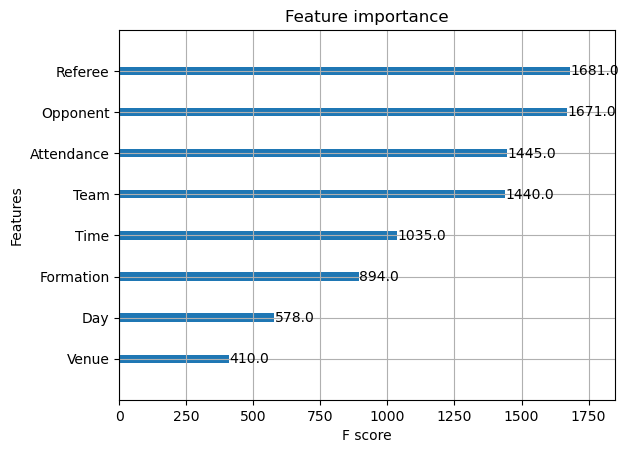

In [22]:
xgb.plot_importance(model)

### Error Analysis

In [23]:
error= [not accuracy[i] for i in range(len(accuracy))]

In [24]:
true=PL["matches"].iloc[1825:][accuracy].value_counts("Referee")
false=PL["matches"].iloc[1825:][error].value_counts("Referee")
pd.concat([false,true],axis=1)

,0,1
Referee,,
Anthony Taylor,12,20
Craig Pawson,12,20
Kevin Friend,11,15
Mike Dean,10,22
Michael Oliver,10,16
Andy Madley,10,8
Jonathan Moss,10,20
Peter Bankes,8,6
Paul Tierney,8,24


In [25]:
true=PL["matches"].iloc[1825:][accuracy].value_counts("Team")
false=PL["matches"].iloc[1825:][error].value_counts("Team")
pd.concat([false,true],axis=1)

,0,1
Team,,
Tottenham,11,13
Chelsea,11,11
Leicester City,11,12
Aston Villa,10,13
Newcastle Utd,10,13
Brighton,9,14
Wolves,8,14
Brentford,8,14
Southampton,8,15


In [26]:
true=PL["matches"].iloc[1825:][accuracy].value_counts("Opponent")
false=PL["matches"].iloc[1825:][error].value_counts("Opponent")
pd.concat([false,true],axis=1)

,0,1
Opponent,,
Everton,12,11
Norwich City,12,11
Wolves,10,12
Burnley,10,14
Southampton,10,12
Leeds United,10,12
Brighton,9,14
Tottenham,9,15
Watford,8,14


### Creating column for last 5 matches result for each team

In [27]:
#Detremine predictors features and target
predictors=["Time","Day","Team","Opponent","Venue","Attendance","Formation","Referee","Captain"]

rolling=   ['xG','xGA',"Poss","Performance | PSxG+/-","Performance | PSxG","Total | Cmp%","GCA Types | GCA",
            "SCA Types | SCA","Tackles | TklW","Vs Dribbles | Tkl%", "Int","Clr","Touches | Touches","Dribbles | Succ%",
            "Performance | Recov","Aerial Duels | Won%"]

target=["Result"]
X=PL["matches"][predictors+rolling]
y=PL["matches"][target]

In [28]:
#We will count win and not winning only to make it simple
for i in range(len(y)):
    if y.iloc[i,0]=="W":
        y.iloc[i,0]=1
    else: y.iloc[i,0]=0

In [29]:
#List of features needed to be converted
cateogry=["Day","Team","Opponent","Venue","Formation","Referee","Captain"]
for column in cateogry:
    X[column]=X[column].astype("category").cat.codes
#Convert time to hours only and its type to int
X["Time"]=((X["Time"].str.split(":")).str[0]).astype("int")+(((X["Time"].str.split(":")).str[1]).astype("int")/100)

In [30]:
matches=[]
for team in range(24):
    match=X[X["Team"]==team]
    match=match.join(y)
    match["Last5Pts"]=match["Result"].rolling(5, min_periods=1).sum()
    for stat in rolling:
        match[stat]=match[stat].rolling(5, min_periods=1).mean() 
    matches.append(match)

In [31]:
X=pd.concat(matches).sort_index()
X=X.drop(["Result"], axis=1)

In [32]:
#Splitting Dataset into Training set and Test set with ratio 80%:20%
#The split is done that test set must be after the train set in the date
X_train=X.iloc[:1825]
X_test =X.iloc[1825:]
y_train=y.iloc[:1825]
y_test =y.iloc[1825:]

In [33]:
model=XGBClassifier(n_estimators=100,max_depth=200,random_state=1)
model.fit(X_train,y_train)

C:\Users\othma\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[22:29:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=200, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [34]:
y_predict=model.predict(X_test)
accuracy=[y_test.iloc[i,0]==y_predict[i] for i in range(len(y_test))]
accuracy.count(True)/len(accuracy)

0.7274725274725274

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

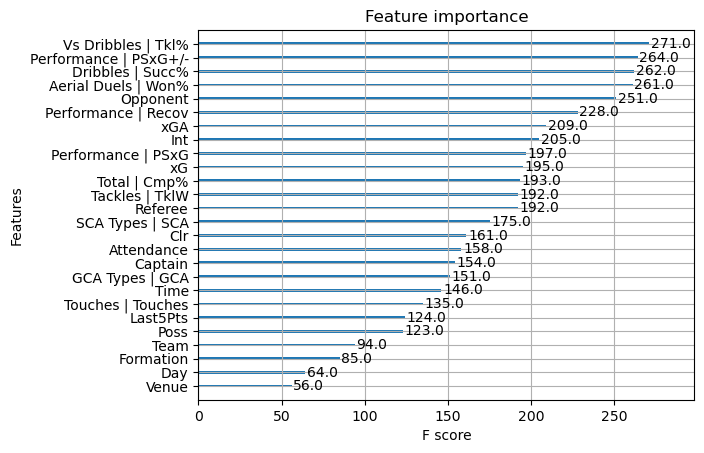

In [35]:
xgb.plot_importance(model)